In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer

warnings.filterwarnings("ignore")
pd.options.display.max_rows = 750
pd.options.display.max_columns = 100

df = pd.read_csv("../input/grunge.csv")

### Function for Printing and Saving
* Confustion Matrix

In [2]:
def print_save_confusion_matrix(test, pred, suffix=''):

    cnf_matrix = confusion_matrix(test, pred, labels=['no', 'yes'])

    fig, axe = plt.subplots(figsize=(5,4))
    ax =sns.heatmap(
        pd.DataFrame(cnf_matrix), 
        annot=True, 
        cmap=sns.light_palette("#459e97", as_cmap=True),
        fmt='g',)
    plt.title('Confusion Matrix of '+suffix.title()+' Model', y=1.1)
    ax.set_xticklabels(['no', 'yes'])
    ax.set_yticklabels(['no', 'yes'])
    axe.tick_params(top=True, labeltop=True)
    plt.ylabel('Actual charting')
    plt.xlabel('Predicted charting')
    plt.savefig('/kaggle/working/Confusion Matrix ['+suffix.lower()+'].png', dpi=300, bbox_inches='tight')
    plt.show()

# 1. Preprocessing

### Creating the target variable `on_chart`

For songs that have not reached any postition on Billboard top lists, column `on_chart` will be an empty string.<br>
Otherwise, column will contain concatenated strings from all Billboard top lists.

In [3]:
df['on_chart'] = df.iloc[:,33:].replace(np.nan, '').astype(str).apply(''.join, axis=1).str.strip()

# If column `on_chart` contains empty string - label `no` <br>
# Otherwise - label `yes`
df['on_chart'] = ['yes'  if x != '' else 'no' for x in df['on_chart']]

# Removing all Billboard top lists columns.
df.drop(df.columns[33:97], axis=1, inplace=True)

# `on_chart` - apsolute value counts.
print(df['on_chart'].value_counts())
print(df.shape)

on_chart
no     644
yes     63
Name: count, dtype: int64
(707, 34)


### Creating new index as `track_name` + `album_name`

In [4]:
df['id'] = df.iloc[:,[0,1]].apply(', '.join, axis=1)
df.drop(['track_name','album_name'], axis=1, inplace=True)
df.set_index('id', inplace=True)

### Isolating numerical features

In [5]:
data = df.iloc[:,np.r_[1:3,4:16,30, -1]]

### Missing Data Imputation

In [6]:
data.isna().sum()

duration             0
release_year         0
acousticness         0
danceability         0
energy               0
instrumentalness     0
key                  0
liveness             0
loudness             0
mode                 0
speechiness          0
tempo                0
time_signature       0
valence              0
album_rating        61
on_chart             0
dtype: int64

In [7]:
print(f'Percentage of missing values of album_rating: {data.album_rating.isna().sum()/data.shape[0]*100:.2} %\n')
print('Frequencies')
print(data.album_rating.value_counts(dropna=False))

Percentage of missing values of album_rating: 8.6 %

Frequencies
album_rating
4.0    269
3.0    106
4.5    102
5.0     87
NaN     61
2.5     42
3.5     38
2.0      2
Name: count, dtype: int64


In [8]:
imputer = KNNImputer(n_neighbors=1)
imputed_data = pd.DataFrame(imputer.fit_transform(data.drop('on_chart', axis=1)), columns=data.columns[:-1])

imputed_data.set_index(data.index.values, inplace=True)

imputed = pd.DataFrame({'imputed': imputed_data['album_rating'].value_counts()})
original = pd.DataFrame({'original': data.album_rating.value_counts()})
compare_imputed = pd.concat([imputed, original], axis=1)
compare_imputed['diff'] = compare_imputed.imputed - compare_imputed.original
compare_imputed

,imputed,original,diff
album_rating,,,
4.0,295,269,26
4.5,116,102,14
3.0,115,106,9
5.0,97,87,10
2.5,43,42,1
3.5,39,38,1
2.0,2,2,0


In [9]:
data['album_rating'] = pd.Series(imputed_data['album_rating'])

### Feature Selection - Mutual Information

In [10]:
X = data.drop('on_chart', axis=1) # Features
y = data['on_chart'] # Target variable

mi_scores = pd.DataFrame(data={'mi':MIC(X, y, random_state=2024)},index=X.columns)
to_keep = mi_scores.mi[mi_scores.mi>0.02].index

X = X[to_keep]
X.head()

,release_year,liveness,speechiness,time_signature,album_rating
id,,,,,
"Blew, Bleach",1989,0.2980,0.0556,4,3.5
"Floyd The Barber, Bleach",1989,0.0623,0.0418,4,3.5
"About A Girl, Bleach",1989,0.2090,0.0310,4,3.5
"School, Bleach",1989,0.0739,0.0785,4,3.5
"Love Buzz, Bleach",1989,0.1820,0.0339,4,3.5


# 2. Building Base Model

### Splitting the Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2024)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

on_chart
no     0.909735
yes    0.090265
Name: proportion, dtype: float64
on_chart
no     0.915493
yes    0.084507
Name: proportion, dtype: float64


### Feature Scaling

In [12]:
X_train.describe()

,release_year,liveness,speechiness,time_signature,album_rating
count,565.000000,565.000000,565.000000,565.000000,565.000000
mean,2002.408850,0.278196,0.062323,3.851327,3.935398
std,8.515584,0.253772,0.039855,0.561014,0.697503
min,1989.000000,0.028000,0.000000,0.000000,2.000000
25%,1995.000000,0.104000,0.036100,4.000000,3.500000
50%,2002.000000,0.170000,0.050100,4.000000,4.000000
75%,2009.000000,0.355000,0.074600,4.000000,4.500000
max,2020.000000,0.993000,0.356000,5.000000,5.000000


In [13]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Training Base Model
* K is set to **3**

In [14]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

print(f'Testing accuracy:\t{accuracy_score(y_test, y_pred)*100:.4}%\n')

print(f"Testing precision:\t{precision_score(y_test, y_pred, pos_label='no')*100:.4}%\n")

print(f"Testing recall:\t\t{recall_score(y_test, y_pred, pos_label='no')*100:.4}%\n")

print(f"Testing f1 score:\t{f1_score(y_test, y_pred, pos_label='no')*100:.4}%\n")

Testing accuracy:	84.51%

Testing precision:	93.55%

Testing recall:		89.23%

Testing f1 score:	91.34%



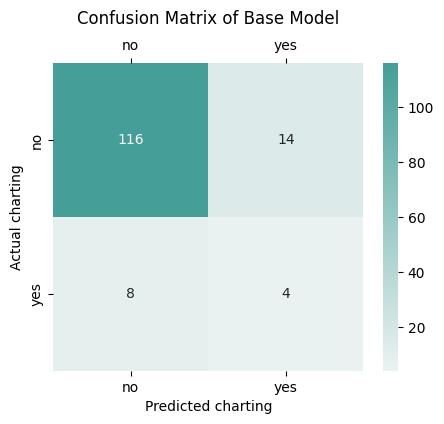

In [15]:
print_save_confusion_matrix(y_test, y_pred, suffix='base')

# 3. Hyperparameter Optimization

### Plotting Value of K VS. Validation Scores

* K is set to values between **1** and **30**

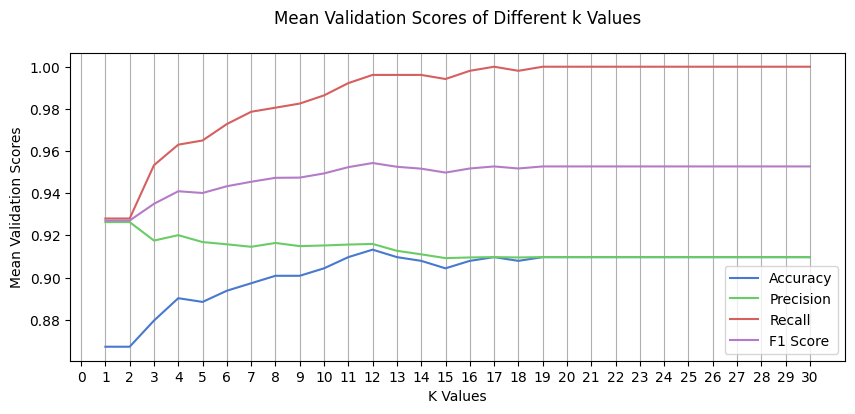

In [16]:
k_values = [i for i in range (1,31)]
validation_scores_a = []
validation_scores_p = []
validation_scores_r = []
validation_scores_f = []
p = make_scorer(precision_score, pos_label='no')
r = make_scorer(recall_score, pos_label='no')
f = make_scorer(f1_score, pos_label='no')

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k,  weights='distance')
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    
    validation_score_a = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    validation_scores_a.append(np.mean(validation_score_a))
    
    validation_score_p = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring=p)
    validation_scores_p.append(np.mean(validation_score_p))
    
    validation_score_r = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring=r)
    validation_scores_r.append(np.mean(validation_score_r))
    
    validation_score_f = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring=f)
    validation_scores_f.append(np.mean(validation_score_f))

fig = plt.figure(figsize=(10,4))
plt.style.use('seaborn-v0_8-muted')
plt.plot(k_values,validation_scores_a, label='Accuracy')
plt.plot(k_values,validation_scores_p, label='Precision')
plt.plot(k_values,validation_scores_r, label='Recall')
plt.plot(k_values,validation_scores_f, label='F1 Score')
plt.title('Mean Validation Scores of Different k Values\n')
plt.xticks(ticks=range(0,31))
plt.xlabel("K Values")
plt.ylabel("Mean Validation Scores")
plt.grid(axis='x')
plt.legend()
plt.savefig('/kaggle/working/Mean Validation Scores VS. k Values.png', dpi=300, bbox_inches='tight')
plt.show()

### Scores Table View
* Each cell contains a tuple (k, score)

In [17]:
scores = pd.DataFrame({'Accuracy' : [(i, validation_scores_a[i-1]) for i in range(1,31)]}).sort_values(by='Accuracy', ascending=False,key=lambda x: x.apply(lambda y:y[1])).reset_index(drop=True)
scores['Precision'] = sorted([(i, validation_scores_p[i-1]) for i in range(1,31)], key=lambda x: x[1], reverse=True)
scores['Recall'] = sorted([(i, validation_scores_r[i-1]) for i in range(1,31)], key=lambda x: x[1], reverse=True)
scores['F1 Scores'] = sorted([(i, validation_scores_f[i-1]) for i in range(1,31)], key=lambda x: x[1], reverse=True)

scores.head()

,Accuracy,Precision,Recall,F1 Scores
0,"(12, 0.9132743362831859)","(1, 0.9263400055866894)","(17, 1.0)","(12, 0.9543475148912425)"
1,"(30, 0.9097345132743362)","(2, 0.9263400055866894)","(19, 1.0)","(17, 0.9527304048234282)"
2,"(22, 0.9097345132743362)","(4, 0.9201449395721639)","(20, 1.0)","(19, 0.9527304048234282)"
3,"(19, 0.9097345132743362)","(3, 0.9175777130952827)","(21, 1.0)","(20, 0.9527304048234282)"
4,"(20, 0.9097345132743362)","(5, 0.9168747523290811)","(22, 1.0)","(21, 0.9527304048234282)"


### Training Optimized Model
* K is set to **12**

In [18]:
best_knn = KNeighborsClassifier(n_neighbors=12, weights='distance')
best_knn.fit(X_train_scaled, y_train)

y_pred_best_knn = best_knn.predict(X_test_scaled)

print(f'Testing accuracy:\t{accuracy_score(y_test, y_pred_best_knn)*100:.4}%\n')

print(f"Testing precision:\t{precision_score(y_test, y_pred_best_knn, pos_label='no')*100:.4}%\n")

print(f"Testing recall:\t\t{recall_score(y_test, y_pred_best_knn, pos_label='no')*100:.4}%\n")

print(f"Testing f1 score:\t{f1_score(y_test, y_pred_best_knn, pos_label='no')*100:.4}%\n")

Testing accuracy:	88.73%

Testing precision:	92.54%

Testing recall:		95.38%

Testing f1 score:	93.94%



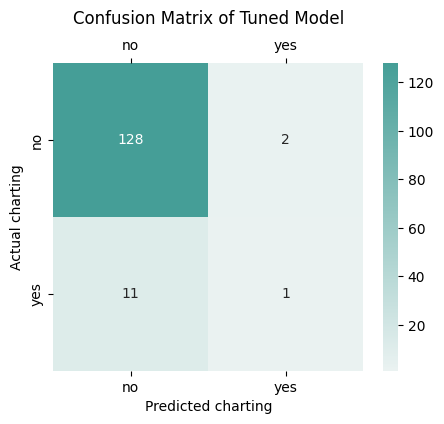

In [19]:
print_save_confusion_matrix(y_test, y_pred, suffix='tuned')